In [1]:
import numpy as np
import pandas as pd
import os
import librosa 
from scipy.io import wavfile as wav
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import tensorflow 

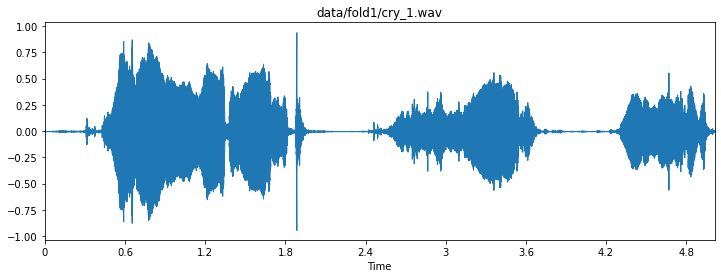

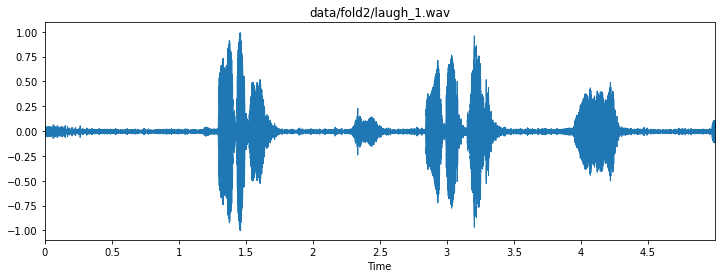

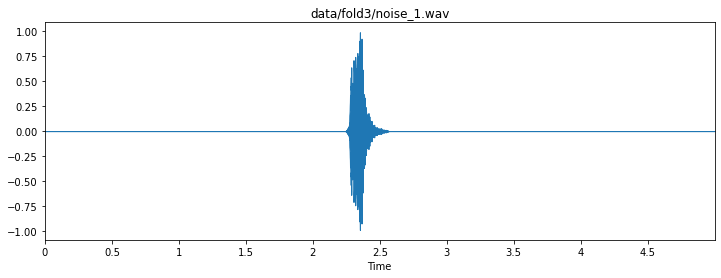

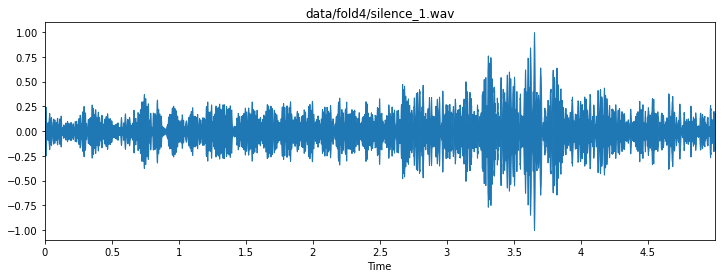

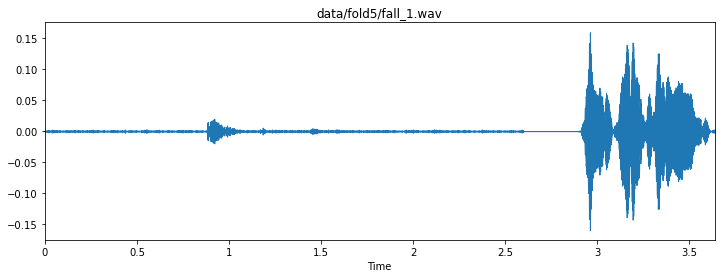

In [2]:
filename_cry = 'data/fold1/cry_1.wav'
filename_laugh = 'data/fold2/laugh_1.wav'
filename_noise = 'data/fold3/noise_1.wav'
filename_silence = 'data/fold4/silence_1.wav'
filename_fall = 'data/fold5/fall_1.wav'

example_list = [filename_cry, filename_laugh, filename_noise, filename_silence, filename_fall]
librosa_sample_rate  = 0


def draw_sound(filename):
    plt.figure(figsize = (12, 4))
    data, librosa_sample_rate  = librosa.load(filename)
    plt.title(filename)
    _ = librosa.display.waveplot(data, sr = librosa_sample_rate )
    
for i in  example_list:
    draw_sound(i)

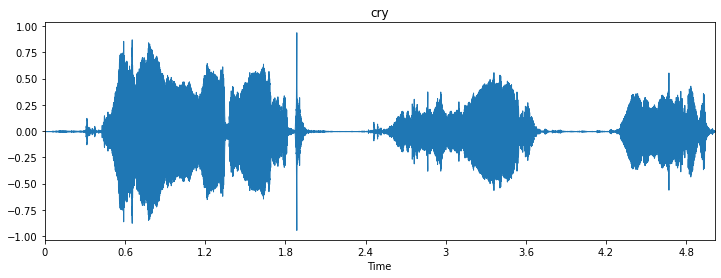

In [3]:
plt.figure(figsize = (12, 4))
data, librosa_sample_rate  = librosa.load('data/fold1/cry_1.wav')
plt.title('cry')
_ = librosa.display.waveplot(data, sr = librosa_sample_rate )

In [4]:
import librosa 
from scipy.io import wavfile as wav

import numpy as np

filename = 'data/fold1/cry_1.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

mfccs = librosa.feature.mfcc(y = librosa_audio, sr = librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)

Original sample rate: 44100
Librosa sample rate: 22050
(40, 216)


In [5]:
import numpy as np
max_pad_len = 237
test_num = 0

def extract_features(file_name):
      audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
      mfccs = librosa.feature.mfcc(y=audio, sr = sample_rate, n_mfcc = 40)
      pad_width = max_pad_len - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width = ((0, 0), (0, pad_width)), mode = 'constant')
      global max
      if mfccs.shape[1] > max:
        max = mfccs.shape[1]

    
      return mfccs

In [6]:
import pandas as pd
import os
import librosa
max = 0
fulldatasetpath = 'data/'
metadata = pd.read_csv("data/sound3.csv")
features = []

for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))   
    class_label = row['class_name']
    data = extract_features(file_name)   
    features.append([data, class_label])

featuresdf = pd.DataFrame(features, columns = ['feature', 'class_label'])

print("Finished feature extraction from ", len(featuresdf), ' files') 
print('Max :',max)

Finished feature extraction from  540  files
Max : 237


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

x = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, yy, test_size = 0.2, random_state = 42)

In [9]:
x_train.shape

(432, 40, 237)

In [10]:
num_rows = 40
num_columns = 237
num_channels = 1

print("train data shape")
print(x_train.shape)
print(x_test.shape)

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

print("\ntrain data reshape 결과")
print(x_train.shape)
print(x_test.shape)

train data shape
(432, 40, 237)
(108, 40, 237)

train data reshape 결과
(432, 40, 237, 1)
(108, 40, 237, 1)


In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

num_labels = yy.shape[1]
filter_size = 2

#CNN모델 구현
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 2, input_shape = (num_rows, num_columns, num_channels), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation = 'softmax'))


#컴파일
model.compile(loss = 'categorical_crossentropy'
    , metrics = ['accuracy']
    , optimizer = 'adam')
                
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 236, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 118, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 118, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 117, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 58, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 58, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 57, 64)         8

In [12]:
hist = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=128,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/100
4/4 [==============================] - 1s 277ms/step - loss: 7.3834 - accuracy: 0.2153 - val_loss: 2.5779 - val_accuracy: 0.2963
Epoch 2/100
4/4 [==============================] - 1s 238ms/step - loss: 3.1936 - accuracy: 0.4120 - val_loss: 1.3302 - val_accuracy: 0.4722
Epoch 3/100
4/4 [==============================] - 1s 233ms/step - loss: 1.9464 - accuracy: 0.4236 - val_loss: 1.1936 - val_accuracy: 0.6667
Epoch 4/100
4/4 [==============================] - 1s 224ms/step - loss: 1.1932 - accuracy: 0.6759 - val_loss: 0.9804 - val_accuracy: 0.6574
Epoch 5/100
4/4 [==============================] - 1s 221ms/step - loss: 1.3922 - accuracy: 0.6181 - val_loss: 0.8874 - val_accuracy: 0.7500
Epoch 6/100
4/4 [==============================] - 1s 222ms/step - loss: 0.9214 - accuracy: 0.7431 - val_loss: 0.9003 - val_accuracy: 0.7407
Epoch 7/100
4/4 [==============================] - 1s 222ms/step - loss: 0.8025 - accuracy: 0.7407 - val_loss: 0.6674 - val_accuracy: 0.7593
Epoch 8/100
4

In [13]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

4/4 [==============================] - 0s 12ms/step - loss: 0.1919 - accuracy: 0.9444
loss_and_metrics : [0.19192014634609222, 0.9444444179534912]


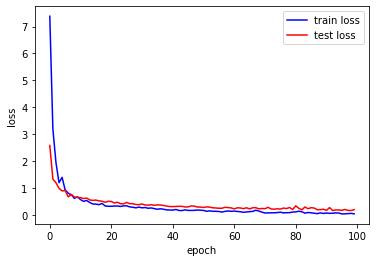

In [14]:
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label= 'test loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc = 'upper right')
plt.show()

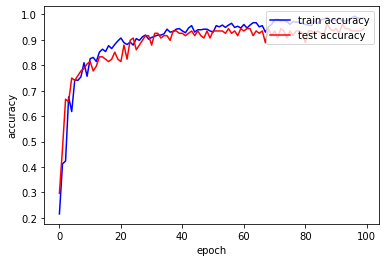

In [27]:
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
loss_ax.plot(hist.history['val_accuracy'], 'r', label = 'test accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper right')

plt.show()

In [15]:
def predict_fatures(file_name):
    max_ped_len = 237
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    pad_width = max_ped_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mfccs = mfccs.reshape(1, 40, 237, 1)
    
    return mfccs

In [16]:
def print_prediction(file_name):
    prediction_feature = predict_fatures(file_name) 
    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [17]:
filename = 'data/fold1/cry_1.wav'
print_prediction(filename) 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
The predicted class is: cry 

Instructions for updating:
Please use `model.predict()` instead.
cry 		 :  0.79602789878845214843750000000000
fall 		 :  0.00020246546773705631494522094727
laugh 		 :  0.00004302167508285492658615112305
noise 		 :  0.20372609794139862060546875000000
silence 		 :  0.00000046953189780651882756501436


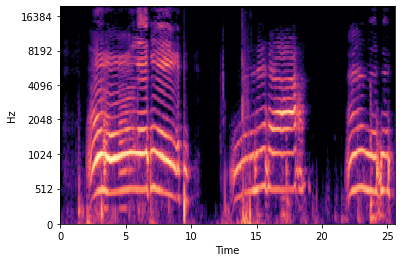

In [18]:
y, sr = librosa.load('data/fold1/cry_1.wav')                
yt,_=librosa.effects.trim(y)                          
y=yt
# Creare spectrogram from audio file
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')

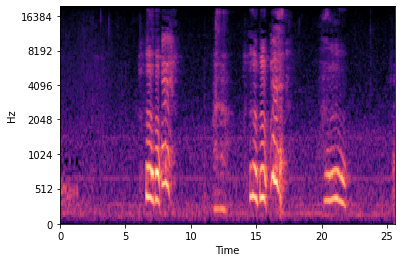

In [19]:
y, sr = librosa.load('data/fold2/laugh_1.wav')                
yt,_=librosa.effects.trim(y)                          
y=yt
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')

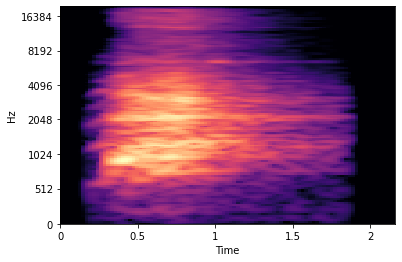

In [20]:
y, sr = librosa.load('data/fold3/noise_1.wav')                
yt,_=librosa.effects.trim(y)                          
y=yt
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')

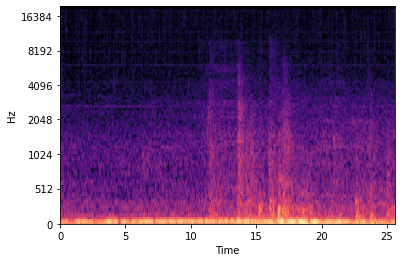

In [21]:
y, sr = librosa.load('data/fold4/silence_1.wav')                
yt,_=librosa.effects.trim(y)                          
y=yt
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')

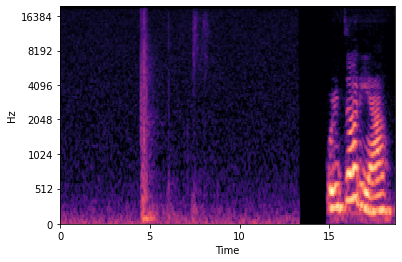

In [22]:
y, sr = librosa.load('data/fold5/fall_1.wav')                
yt,_=librosa.effects.trim(y)                          
y=yt
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')